In [0]:
# Chainer, Cupyのインストール
!curl https://colab.chainer.org/install | sh -

# Chainerでクラス分類

### データの読み込み

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('wine-class.csv')

In [0]:
df.head(3)

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,1,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,1,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185


In [0]:
df.tail(3)

,Class,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
175,3,13.27,2.26,20.0,120,1.59,0.69,0.43,10.2,0.59,835
176,3,13.17,2.37,20.0,120,1.65,0.68,0.53,9.3,0.60,840
177,3,14.13,2.74,24.5,96,2.05,0.76,0.56,9.2,0.61,560


## 入力変数と教師データ（出力変数）に切り分ける

In [0]:
# df.iloc[行, 列]
t = df.iloc[:,0]

In [0]:
# 一番目から最後まで
x = df.iloc[:,1:]

In [0]:
x.head(3)

,Alcohol,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Color intensity,Hue,Proline
0,14.23,2.43,15.6,127,2.80,3.06,0.28,5.64,1.04,1065
1,13.20,2.14,11.2,100,2.65,2.76,0.26,4.38,1.05,1050
2,13.16,2.67,18.6,101,2.80,3.24,0.30,5.68,1.03,1185


In [0]:
x.shape

(178, 10)

In [0]:
type(t)

pandas.core.series.Series

In [0]:
type(x)

pandas.core.frame.DataFrame

In [0]:
type(x.values)

numpy.ndarray

In [0]:
t = t.values - 1
x = x.values

In [0]:
t.dtype

dtype('int64')

In [0]:
x.dtype

dtype('float64')

In [0]:
x = x.astype('f')
t = t.astype('i')

In [0]:
x.dtype

dtype('float32')

In [0]:
t.dtype

dtype('int32')

## Chainerで資料するデータセットの形式
タプルをリストで囲む

$
[(x_1^T , t_1),(x_2^T , t_2),....,(x_N^T , t_N)]
$

In [0]:
dataset = list(zip(x,t))

In [0]:
dataset

[(array([1.423e+01, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00, 3.060e+00,
         2.800e-01, 5.640e+00, 1.040e+00, 1.065e+03], dtype=float32), 0),
 (array([1.32e+01, 2.14e+00, 1.12e+01, 1.00e+02, 2.65e+00, 2.76e+00,
         2.60e-01, 4.38e+00, 1.05e+00, 1.05e+03], dtype=float32), 0),
 (array([1.316e+01, 2.670e+00, 1.860e+01, 1.010e+02, 2.800e+00, 3.240e+00,
         3.000e-01, 5.680e+00, 1.030e+00, 1.185e+03], dtype=float32), 0),
 (array([1.437e+01, 2.500e+00, 1.680e+01, 1.130e+02, 3.850e+00, 3.490e+00,
         2.400e-01, 7.800e+00, 8.600e-01, 1.480e+03], dtype=float32), 0),
 (array([1.324e+01, 2.870e+00, 2.100e+01, 1.180e+02, 2.800e+00, 2.690e+00,
         3.900e-01, 4.320e+00, 1.040e+00, 7.350e+02], dtype=float32), 0),
 (array([1.42e+01, 2.45e+00, 1.52e+01, 1.12e+02, 3.27e+00, 3.39e+00,
         3.40e-01, 6.75e+00, 1.05e+00, 1.45e+03], dtype=float32), 0),
 (array([1.439e+01, 2.450e+00, 1.460e+01, 9.600e+01, 2.500e+00, 2.520e+00,
         3.000e-01, 5.250e+00, 1.020e+00, 1.290e+03

## 訓練データと検証データに分割

In [0]:
len(dataset)

178

In [0]:
n_train = int(len(dataset) * 0.7)
n_train

124

In [0]:
train, test = chainer.datasets.split_dataset_random(dataset,n_train,seed=1)

In [0]:
len(train)

124

In [0]:
len(test)

54

## ニューラルネットワークのモデルを定義

In [0]:
import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L

改善前
```python
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(10,5)
            self.fc2 = L.Linear(5,3)

    # 順伝播
    def __call__(self, x):
        u1 = self.fc1(x)
        z1 = F.relu(u1)
        u2 = self.fc2(z1)
        return u2
```

In [0]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units)
            self.fc2 = L.Linear(None,n_out)

    # 順伝播　h:hidden
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [0]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)

## 学習するための設定

### Optimizerの設定

In [0]:
optimizer = chainer.optimizers.SGD() #確率的勾配降下法

In [0]:
optimizer.setup(model)

### Iteratorの設定
ミニバッチ学習

In [0]:
batchsize = 10

In [0]:
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

### Updaterの設定
使用するデバイスの設定
- CPU: -1
- GPU: 0 （割り当てID）

In [0]:
from chainer import training

In [0]:
updater = training.StandardUpdater(train_iter,optimizer,device=-1)

### TrainerとExtensionsの設定

In [0]:
from chainer.training import extensions

In [0]:
#エポック数
epoch = 50

In [0]:
#Trainerの宣言
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/wine')

#検証データで評価
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))

trainer.extend(extensions.LogReport(trigger=(1,'epoch')))

#1エポック毎（trigger）にtrainデータに対するloss/accuracyとtestデータに対するloss/accuracy、経過時間を出力します。
trainer.extend(
    extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))

## 学習の実行

In [0]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.369231       0.325                     4.46181     1.09865               0.0595884     
2           0.416667       0.341667                  1.09665     1.09864               0.147098      
3           0.407692       0.341667                  1.09587     1.09869               0.279505      
4           0.425          0.341667                  1.09379     1.09879               0.42561       
5           0.416667       0.341667                  1.09227     1.09897               0.539118      
6           0.415385       0.341667                  1.09168     1.09917               0.675256      
7           0.433333       0.341667                  1.08893     1.09944               0.78592       
8           0.384615       0.341667                  1.09221     1.09965               0.931362      
9           0.45           0.341667                  1.08647     1.09996            

## 結果の確認

In [0]:
import json

In [0]:
with open('result/wine/log') as f:
    logs = json.load(f)

In [0]:
logs

[{'main/loss': 4.461814816181477,
  'main/accuracy': 0.3692307730133717,
  'validation/main/loss': 1.098651389280955,
  'validation/main/accuracy': 0.3250000017384688,
  'epoch': 1,
  'iteration': 13,
  'elapsed_time': 0.05958842597740277},
 {'main/loss': 1.0966469049453735,
  'main/accuracy': 0.4166666691501935,
  'validation/main/loss': 1.098640223344167,
  'validation/main/accuracy': 0.34166667113701504,
  'epoch': 2,
  'iteration': 25,
  'elapsed_time': 0.1470983689283851},
 {'main/loss': 1.0958705223523653,
  'main/accuracy': 0.4076923126211533,
  'validation/main/loss': 1.0986918210983276,
  'validation/main/accuracy': 0.34166667113701504,
  'epoch': 3,
  'iteration': 38,
  'elapsed_time': 0.2795051190160541},
 {'main/loss': 1.0937895079453785,
  'main/accuracy': 0.4250000057121118,
  'validation/main/loss': 1.0987934271494548,
  'validation/main/accuracy': 0.34166667113701504,
  'epoch': 4,
  'iteration': 50,
  'elapsed_time': 0.42561004815381853},
 {'main/loss': 1.0922718048095

In [0]:
logs[0]['elapsed_time']

0.05958842597740277

In [0]:
results = pd.DataFrame(logs)

In [0]:
results.head()

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,0.059588,1,13,0.369231,4.461815,0.325000,1.098651
1,0.147098,2,25,0.416667,1.096647,0.341667,1.098640
2,0.279505,3,38,0.407692,1.095871,0.341667,1.098692
3,0.425610,4,50,0.425000,1.093790,0.341667,1.098793
4,0.539118,5,62,0.416667,1.092272,0.341667,1.098974


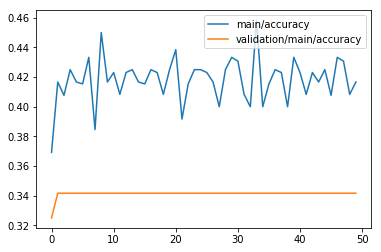

In [0]:
%matplotlib inline
results[['main/accuracy','validation/main/accuracy']].plot()

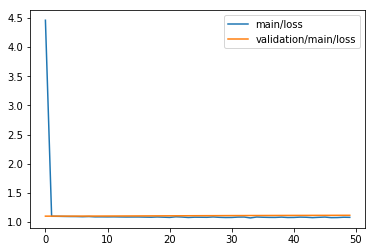

In [0]:
results[['main/loss','validation/main/loss']].plot()

## 実践課題
上記の問題設定にてハイパーパラメータの値などを変更し、精度が80%以上出るようなモデルを作成して下さい。
- 中間層のノード 5 -> 10,100
- 層を増やす
- 活性化関数 relu() -> sigmoid()
- Optimizer SDG -> Adam
- batchsize, epoch

In [0]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units1=20, n_mid_units2=15, n_mid_units3=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units1)
            self.fc2 = L.Linear(None,n_mid_units2)
            self.fc3 = L.Linear(None,n_mid_units3)
            self.fc4 = L.Linear(None,n_out)

    # 順伝播　h:hidden
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        #h = F.sigmoid(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        h = F.relu(h)
        h = self.fc4(h)
        return h

In [0]:
np.random.seed(1)
nn = NN(20,15,10)
model = L.Classifier(nn)

#optimizer = chainer.optimizers.SGD() #確率的勾配降下法
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

batchsize = 10
#batchsize = 20
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

updater = training.StandardUpdater(train_iter,optimizer,device=-1)
#epoch = 50
epoch = 500
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/wine')
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(
    extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.323077       0.325                     12.7743     6.32928               0.0719553     
2           0.491667       0.425                     2.93509     1.49008               0.232123      
3           0.569231       0.566667                  1.21982     1.05275               0.361928      
4           0.616667       0.675                     0.969115    0.775644              0.494549      
5           0.691667       0.55                      0.831912    0.845151              0.617168      
6           0.592308       0.583333                  0.863473    0.765592              0.754185      
7           0.65           0.533333                  0.781707    0.799125              0.882802      
8           0.576923       0.6                       0.844691    0.86718               1.02157       
9           0.658333       0.675                     0.784242    0.714696           

81          0.930769       0.808333                  0.271765    0.431119              15.4849       
82          0.925          0.833333                  0.290777    0.437627              15.6234       
83          0.923077       0.716667                  0.273091    0.486739              15.7771       
84          0.916667       0.866667                  0.261615    0.418893              15.9042       
85          0.908333       0.866667                  0.256409    0.347479              16.0544       
86          0.915385       0.791667                  0.26784     0.428224              16.2082       
87          0.925          0.716667                  0.270871    0.43526               16.3581       
88          0.946154       0.866667                  0.248088    0.369898              16.5252       
89          0.916667       0.85                      0.26033     0.339609              16.6605       
90          0.908333       0.683333                  0.261633    0.512448         

162         0.958333       0.866667                  0.150002    0.270472              31.6155       
163         0.961538       0.916667                  0.121461    0.249569              31.8174       
164         0.975          0.916667                  0.123615    0.224005              31.9608       
165         0.933333       0.9                       0.147268    0.222081              32.1106       
166         0.907692       0.866667                  0.21776     0.341485              32.2978       
167         0.95           0.883333                  0.137963    0.277467              32.5159       
168         0.946154       0.883333                  0.136357    0.231026              32.69         
169         0.958333       0.866667                  0.117512    0.297435              32.8842       
170         0.941667       0.866667                  0.14954     0.329381              33.0602       
171         0.969231       0.9                       0.131651    0.238595         

244         0.916667       0.883333                  0.181596    0.332115              48.8102       
245         0.95           0.9                       0.114734    0.225318              49.0056       
246         0.961538       0.9                       0.131196    0.220114              49.2077       
247         0.966667       0.9                       0.0847956   0.241163              49.4548       
248         0.969231       0.916667                  0.10588     0.221096              49.6496       
249         0.983333       0.883333                  0.0755318   0.359218              49.8297       
250         0.958333       0.866667                  0.118909    0.268578              50.0275       
251         0.961538       0.85                      0.10904     0.29963               50.2001       
252         0.975          0.883333                  0.0946987   0.229984              50.3506       
253         0.961538       0.9                       0.102151    0.202759         

325         0.975          0.9                       0.0895509   0.211065              68.7432       
326         0.961538       0.916667                  0.154543    0.224147              69.081        
327         0.966667       0.883333                  0.104505    0.371563              69.2788       
328         0.923077       0.933333                  0.136454    0.206602              69.4656       
329         0.966667       0.85                      0.102668    0.329253              69.6687       
330         0.95           0.866667                  0.116659    0.313018              69.9168       
331         0.953846       0.9                       0.165073    0.206389              70.0948       
332         0.95           0.825                     0.120817    0.502892              70.2846       
333         0.961538       0.883333                  0.107234    0.262594              70.5462       
334         0.95           0.883333                  0.118698    0.280066         

406         0.976923       0.883333                  0.0657911   0.219889              92.605        
407         0.983333       0.883333                  0.0719005   0.232522              92.8835       
408         0.984615       0.866667                  0.0543277   0.256504              93.2606       
409         0.975          0.866667                  0.0750004   0.287033              93.5362       
410         0.958333       0.866667                  0.0781971   0.356247              93.7662       
411         0.946154       0.883333                  0.12035     0.303273              93.9888       
412         0.95           0.85                      0.0985348   0.298749              94.2004       
413         0.976923       0.9                       0.0739117   0.233881              94.3977       
414         0.941667       0.883333                  0.128932    0.262262              94.6058       
415         0.933333       0.9                       0.131585    0.264672         

487         0.991667       0.866667                  0.0498055   0.286704              116.137       
488         0.961538       0.9                       0.0768774   0.200444              116.529       
489         0.975          0.9                       0.0599264   0.20508               116.973       
490         0.966667       0.85                      0.069431    0.335164              117.393       
491         0.976923       0.9                       0.0760896   0.247219              117.801       
492         0.958333       0.883333                  0.0617241   0.325526              118.222       
493         0.961538       0.9                       0.082108    0.228024              118.651       
494         0.966667       0.9                       0.0932813   0.252515              118.965       
495         0.983333       0.883333                  0.0624719   0.27774               119.32        
496         0.969231       0.883333                  0.0631332   0.25546          

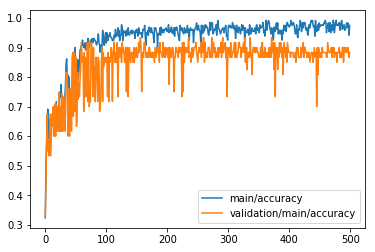

In [0]:
with open('result/wine/log') as f:
    logs = json.load(f)
results = pd.DataFrame(logs)
results[['main/accuracy','validation/main/accuracy']].plot()

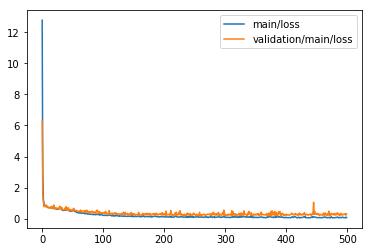

In [0]:
results[['main/loss','validation/main/loss']].plot()

## 解答例
- とりあえずAdam
- 学習傾向あればepoch数増やす
- バッチノーマリゼーション：バッチごとに標準化

In [0]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units)
            self.fc2 = L.Linear(None,n_out)

    # 順伝播　h:hidden
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        #h = F.sigmoid(h)
        h = self.fc2(h)
        return h

In [0]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)

#optimizer = chainer.optimizers.SGD() #確率的勾配降下法
optimizer = chainer.optimizers.Adam() #とりあえずAdam
optimizer.setup(model)

batchsize = 10
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

updater = training.StandardUpdater(train_iter,optimizer,device=-1)
epoch = 500
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/wine')
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(
    extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.523077       0.533333                  1.65499     1.37915               0.0484964     
2           0.616667       0.641667                  1.0913      0.982839              0.210405      
3           0.592308       0.591667                  1.06158     1.00536               0.346381      
4           0.608333       0.591667                  1.05069     0.998432              0.50335       
5           0.633333       0.591667                  0.99029     0.936973              0.631042      
6           0.630769       0.591667                  0.969575    0.892001              0.773212      
7           0.641667       0.608333                  0.915318    0.884763              0.895838      
8           0.638462       0.591667                  0.856485    0.841321              1.02751       
9           0.6            0.608333                  0.869592    0.814115           

81          0.815385       0.783333                  0.517659    0.588257              14.505        
82          0.783333       0.683333                  0.534553    0.607008              14.707        
83          0.792308       0.8                       0.525015    0.57995               14.8954       
84          0.841667       0.725                     0.489583    0.611989              15.0885       
85          0.841667       0.683333                  0.504894    0.598322              15.2486       
86          0.8            0.8                       0.510508    0.60061               15.4416       
87          0.825          0.725                     0.486169    0.575217              15.8042       
88          0.830769       0.725                     0.473824    0.583569              16.0205       
89          0.833333       0.725                     0.496013    0.575477              16.2719       
90          0.858333       0.8                       0.48168     0.542983         

163         0.892308       0.866667                  0.303905    0.343269              30.6389       
164         0.916667       0.9                       0.256962    0.339607              30.865        
165         0.9            0.866667                  0.276933    0.34111               31.0638       
166         0.907692       0.866667                  0.279836    0.336392              31.2976       
167         0.925          0.866667                  0.272676    0.339496              31.459        
168         0.907692       0.866667                  0.268379    0.381707              31.6069       
169         0.891667       0.95                      0.298026    0.296213              31.7554       
170         0.908333       0.883333                  0.28062     0.340161              31.9426       
171         0.892308       0.916667                  0.290433    0.31918               32.1247       
172         0.916667       0.866667                  0.253283    0.369996         

244         0.925          0.916667                  0.213913    0.251657              47.4187       
245         0.908333       0.933333                  0.216029    0.257252              47.641        
246         0.907692       0.95                      0.227759    0.243883              47.8092       
247         0.916667       0.933333                  0.198216    0.251509              47.9938       
248         0.923077       0.933333                  0.214198    0.255448              48.171        
249         0.9            0.95                      0.216312    0.248427              48.3557       
250         0.908333       0.933333                  0.212364    0.261972              48.539        
251         0.915385       0.916667                  0.211762    0.261216              48.7395       
252         0.925          0.95                      0.205834    0.24967               49.0231       
253         0.9            0.933333                  0.208298    0.243681         

325         0.933333       0.916667                  0.180751    0.239017              63.8693       
326         0.923077       0.9                       0.177311    0.267977              64.078        
327         0.916667       0.916667                  0.180066    0.233728              64.385        
328         0.923077       0.9                       0.192305    0.267733              64.6637       
329         0.933333       0.916667                  0.16519     0.254519              64.8391       
330         0.916667       0.933333                  0.18079     0.22638               65.0852       
331         0.930769       0.9                       0.185289    0.246342              65.2685       
332         0.941667       0.916667                  0.171381    0.230237              65.472        
333         0.923077       0.9                       0.185225    0.264796              65.7047       
334         0.933333       0.9                       0.168771    0.242337         

406         0.946154       0.916667                  0.150539    0.238635              83.4404       
407         0.925          0.916667                  0.165185    0.222276              83.715        
408         0.946154       0.9                       0.145532    0.233197              83.9646       
409         0.916667       0.9                       0.188564    0.243772              84.1874       
410         0.941667       0.933333                  0.137049    0.204072              84.4156       
411         0.938462       0.916667                  0.150389    0.240453              84.6731       
412         0.933333       0.933333                  0.15668     0.213232              84.8866       
413         0.930769       0.9                       0.169151    0.277061              85.1378       
414         0.941667       0.933333                  0.149117    0.202816              85.3779       
415         0.941667       0.916667                  0.163148    0.226847         

487         0.925          0.916667                  0.160251    0.233785              103.314       
488         0.946154       0.933333                  0.136879    0.201086              103.638       
489         0.941667       0.933333                  0.142123    0.198146              103.95        
490         0.941667       0.916667                  0.14385     0.214357              104.185       
491         0.930769       0.95                      0.163633    0.193774              104.405       
492         0.958333       0.916667                  0.1095      0.228254              104.633       
493         0.923077       0.933333                  0.154943    0.226946              104.858       
494         0.941667       0.916667                  0.12389     0.223524              105.096       
495         0.933333       0.95                      0.146314    0.189186              105.329       
496         0.946154       0.916667                  0.136635    0.21028          

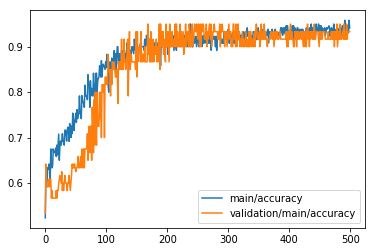

In [0]:
with open('result/wine/log') as f:
    logs = json.load(f)
results = pd.DataFrame(logs)
results[['main/accuracy','validation/main/accuracy']].plot()

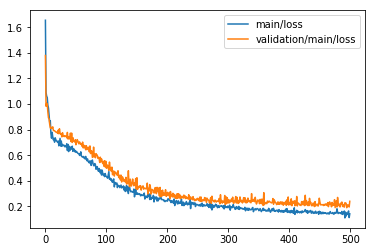

In [0]:
results[['main/loss','validation/main/loss']].plot()

#### バッチノーマリゼーション

In [0]:
class NN(chainer.Chain):
    
    # モデルの構造
    def __init__(self, n_mid_units=5, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units)
            self.fc2 = L.Linear(None,n_out)
            #Batch Normalization
            self.bn = L.BatchNormalization(10) #追記

    # 順伝播　h:hidden
    def __call__(self, x):
        h = self.bn(x) #追記
        h = self.fc1(h)
        h = F.relu(h)
        #h = F.sigmoid(h)
        h = self.fc2(h)
        return h

In [0]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)

#optimizer = chainer.optimizers.SGD() #確率的勾配降下法
optimizer = chainer.optimizers.Adam() #とりあえずAdam
optimizer.setup(model)

batchsize = 10
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

updater = training.StandardUpdater(train_iter,optimizer,device=-1)
epoch = 50
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/wine')
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(
    extensions.PrintReport(['epoch','main/accuracy','validation/main/accuracy','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.407692       0.341667                  1.12051     1.25165               0.0574215     
2           0.508333       0.383333                  1.04718     1.06075               0.223015      
3           0.523077       0.466667                  1.01827     1.01136               0.361861      
4           0.566667       0.466667                  0.947383    0.951842              0.489675      
5           0.591667       0.483333                  0.926922    0.907299              0.619047      
6           0.653846       0.641667                  0.865184    0.880924              0.77023       
7           0.625          0.641667                  0.835717    0.835177              0.89029       
8           0.715385       0.641667                  0.805582    0.801192              1.0281        
9           0.708333       0.658333                  0.778629    0.764299           

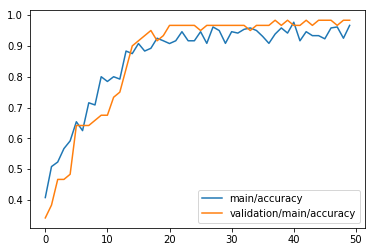

In [0]:
with open('result/wine/log') as f:
    logs = json.load(f)
results = pd.DataFrame(logs)
results[['main/accuracy','validation/main/accuracy']].plot()

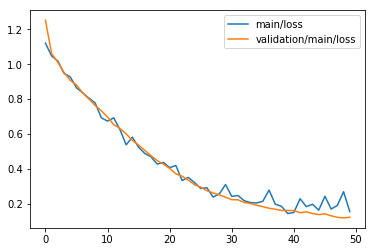

In [0]:
results[['main/loss','validation/main/loss']].plot()

## 学習済みモデルを保存

In [0]:
model

In [0]:
chainer.serializers.save_npz('models/wine.npz',model)

## 学習済みモデルを使用した推論（予測値の計算）

### 学習済みモデルのロード

In [0]:
#モデルの構造を明示
model = L.Classifier(NN())

In [0]:
chainer.serializers.load_npz('models/wine.npz',model)


### 予測値の計算
今回は一番最初のサンプルに対する予測値の計算を行いましょう。

In [0]:
x_new = x[0]
x_new

array([1.423e+01, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00, 3.060e+00,
       2.800e-01, 5.640e+00, 1.040e+00, 1.065e+03], dtype=float32)

In [0]:
x_new.shape

(10,)

In [0]:
#予測値の計算
y = model.predictor(x_new)

InvalidType: 
Invalid operation is performed in: BatchNormalization (Forward)

Expect: in_types[0].ndim >= in_types[1].ndim + 1
Actual: 1 < 2

`バッチサイズ,入力変数の数）`という形式でないといけない

In [0]:
x_new = x_new[np.newaxis]
x_new.shape

(1, 10)

In [0]:
y = model.predictor(x_new)
y

C:\Users\hk\AppData\Local\conda\conda\envs\Chainer\lib\site-packages\chainer\functions\normalization\batch_normalization.py:67: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)


variable([[-0.7482734 ,  0.03190111, -0.85638845]])

In [0]:
y = F.softmax(y)
y

variable([[0.24513546, 0.5348495 , 0.22001502]])

In [0]:
y.array

array([[0.24513546, 0.5348495 , 0.22001502]], dtype=float32)

In [0]:
np.argmax(y.array)

1

In [0]:
t[0]

0